In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import os
import json
from typing import Tuple
from tqdm import tqdm
from model_analysis.model_utils import *
from regression.regression_utils import get_train_test
sns.set(rc={"figure.figsize": (20, 10)})


In [2]:
PATH_TO_DATA = "analysis/data/"
REPETITIONS = 10

In [3]:
def df_to_train_data(df: pd.DataFrame) -> Tuple[np.array, np.array]:
    return df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), df.drop(columns=df.columns[:-1], axis=1)

def run_paredoes(index: int) -> pd.DataFrame:
    # Treinando em n-1 paredões para predizer o n-ésimo
    paredoes_df = {
        "repeticao": [],
        "paredao": [],
        "eliminado": [],
        "rejeicao": [],
        "modelo": [],
        "pred": [],
        "pred_pct": [],
    }
    paredoes = len(os.listdir(PATH_TO_DATA))

    for model in tqdm(MODELS.keys(), desc="- Modelos analisados"):
        
        params = PARAMETERS[model]
        regressor_model = MODELS[model]

        for paredao in range(1, paredoes):
            regressor = regressor_model(**params)
            if NORMALIZE[model]:
                train_df, test_df, mean, std = get_train_test(paredao, normalize=True, drop_columns=REMOVE, data_path=PATH_TO_DATA)
            else:
                train_df, test_df = get_train_test(paredao, normalize=False, drop_columns=REMOVE,  data_path=PATH_TO_DATA)

            x_train, y_train = df_to_train_data(train_df)
            x_test, y_test = df_to_train_data(test_df)

            y_train, y_test = np.ravel(y_train), np.ravel(y_test)

            regressor.fit(x_train, y_train)
            prediction = regressor.predict(x_test)

            if NORMALIZE[model]:
                test_df["predicao"] = prediction * std + mean
                test_df["rejeicao"] =  test_df["rejeicao"] * std + mean
            else:
                test_df["predicao"] = prediction
            
            pred_elimination, pred_pct = test_df.sort_values(by="predicao", ascending=False)[["nome", "predicao"]].iloc[0] 
            true_elimination, true_pct = test_df.sort_values(by="rejeicao", ascending=False)[["nome", "rejeicao"]].iloc[0]
            
            paredoes_df["repeticao"].append(index)
            paredoes_df["paredao"].append(paredao)
            paredoes_df["eliminado"].append(true_elimination)
            paredoes_df["rejeicao"].append(true_pct)
            paredoes_df["modelo"].append(model)
            paredoes_df["pred"].append(pred_elimination)
            paredoes_df["pred_pct"].append(pred_pct)
    
    return pd.DataFrame(paredoes_df)

In [4]:
paredoes_analysis_df = run_paredoes(0)
for index in range(1, REPETITIONS): paredoes_analysis_df = paredoes_analysis_df.append(run_paredoes(index), ignore_index=True)

- Modelos analisados: 100%|██████████| 11/11 [00:24<00:00,  2.21s/it]


In [5]:
paredoes_analysis_df.head()

,repeticao,paredao,eliminado,rejeicao,modelo,pred,pred_pct
0,0,1,lucas_chumbo,0.7594,linear_regression,lucas_chumbo,0.764664
1,0,2,petrix,0.8027,linear_regression,petrix,0.567392
2,0,3,hadson,0.7971,linear_regression,hadson,0.649834
3,0,4,lucas,0.6262,linear_regression,lucas,0.467089
4,0,5,bianca_andrade,0.5309,linear_regression,felipe_prior,0.408430


# Contagem de acertos

In [6]:
paredoes_analysis_df["erro_absoluto"] = abs(paredoes_analysis_df["rejeicao"] - paredoes_analysis_df["pred_pct"])
paredoes_analysis_df["acertos"] = paredoes_analysis_df["eliminado"] == paredoes_analysis_df["pred"]

In [7]:
paredoes_analysis_df[paredoes_analysis_df["repeticao"] == 0]

,repeticao,paredao,eliminado,rejeicao,modelo,pred,pred_pct,erro_absoluto,acertos
0,0,1,lucas_chumbo,0.7594,linear_regression,lucas_chumbo,0.764664,0.005264,True
1,0,2,petrix,0.8027,linear_regression,petrix,0.567392,0.235308,True
2,0,3,hadson,0.7971,linear_regression,hadson,0.649834,0.147266,True
3,0,4,lucas,0.6262,linear_regression,lucas,0.467089,0.159111,True
4,0,5,bianca_andrade,0.5309,linear_regression,felipe_prior,0.408430,0.122470,False
...,...,...,...,...,...,...,...,...,...
182,0,13,flayslene,0.6300,ensamble2,flayslene,0.558680,0.071320,True
183,0,14,gizelly_bicalho,0.5479,ensamble2,gizelly_bicalho,0.582005,0.034105,True
184,0,15,ivy,0.7417,ensamble2,ivy,0.442567,0.299133,True
185,0,16,mari,0.5416,ensamble2,mari,0.597670,0.056070,True


In [8]:
paredoes_analysis_df.to_csv("paredoes.csv")

In [9]:
resultados_medios = paredoes_analysis_df.groupby(["modelo", "paredao"]).mean()
resultados_medios["acertos"] = paredoes_analysis_df[["modelo", "paredao", "acertos"]].groupby(["modelo", "paredao"]).sum().values
resultados_medios.drop(["repeticao", "rejeicao"], axis=1, inplace=True)
resultados_medios.reset_index(inplace=True)


In [10]:
resultados_medios

,modelo,paredao,pred_pct,erro_absoluto,acertos
0,ada_boost,1,0.741171,0.020906,10.0
1,ada_boost,2,0.686070,0.116630,10.0
2,ada_boost,3,0.694635,0.102465,10.0
3,ada_boost,4,0.403958,0.222242,10.0
4,ada_boost,5,0.524526,0.009494,0.0
...,...,...,...,...,...
182,svm,13,0.570600,0.059400,10.0
183,svm,14,0.463960,0.083940,10.0
184,svm,15,0.403211,0.338489,10.0
185,svm,16,0.567365,0.025765,10.0


In [11]:
acertos_medios = resultados_medios[["modelo", "acertos"]].groupby("modelo").sum()
acertos_medios /= REPETITIONS

In [12]:
acertos_medios.sort_values(by="acertos", ascending=False)

,acertos
modelo,
ensamble1,16.0
ensamble2,15.5
svm,15.0
linear_regression,13.0
ridge,13.0
ada_boost,12.9
sgd,12.7
random_forest,12.0
knn,11.0


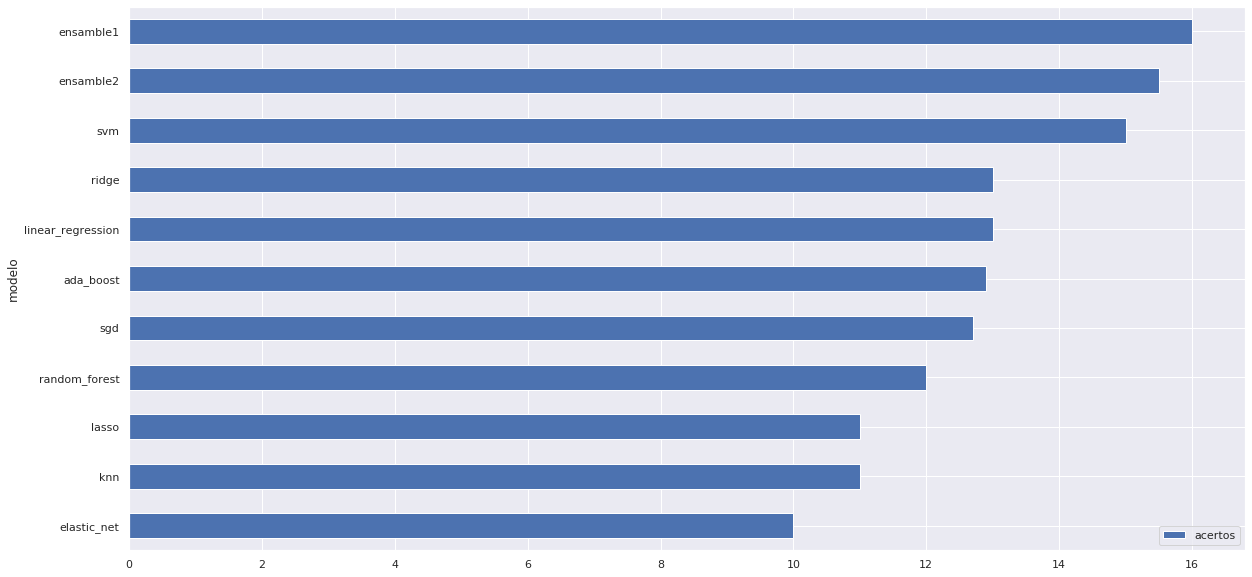

In [13]:
acertos_medios.sort_values(by="acertos").plot.barh()

# Análise de erro absoluto por paredão

In [14]:
resultados_medios.sort_values(by="paredao", inplace=True)
erro_df = resultados_medios.set_index("paredao").pivot(columns="modelo")


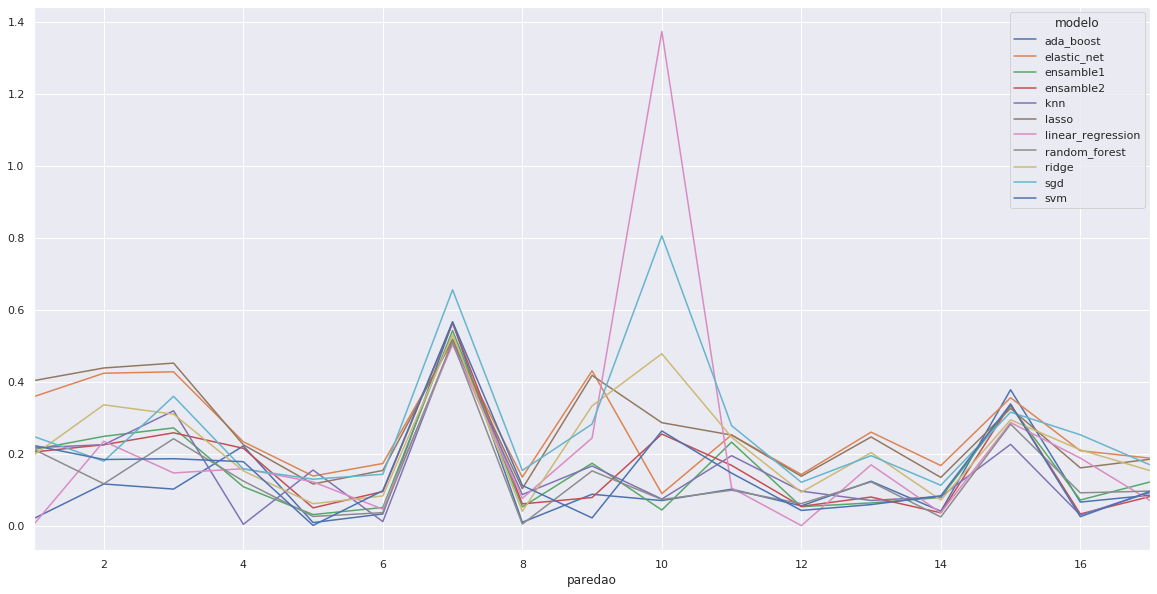

In [15]:
erro_df["erro_absoluto"].plot()

# Acertos em cada paredão

In [16]:
# TODO: Montar uma visualização